<a href="https://colab.research.google.com/github/Glitch0000/Waste_Classification_Custom_VGG/blob/main/Waste_Classification_Custom_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Waste Classification using ResNet:
In this example we will use **[Waste Classification data](https://www.kaggle.com/techsash/waste-classification-data)** dataset to build image classifier using[VGG network](https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c) that can be trained to classify images.


It is primarily made up of a series of Conv2D layers followed by a softmax activated layers to classify the image. As you can see, this will be a handful and the code will look huge if you specify each layer individually. As shown in the lectures, you can instead use model subclassing to build complex architectures. You can encapsulate repeating parts of a network then reuse that code when building the final model. You will get to practice that in this exercise. Let's get started! 

#After loading the zip file the the directory we have to unzip it.
The file contains two folders `train` and `test`, and each one of them contains two files:
- Images of organic items
- Images of recyclable items

 The names of these files will be the name of the two classes that our model will predict.

In [ ]:
!unzip  /content/WASTE_CLASSIFICATION.zip #unzip data in the directory
#It is not possible to include the folders of the images after unziping them
#Note:it is important to separate the name with un underscore.

Streaming output truncated to the last 5000 lines.
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5499.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_55.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_550.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5500.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5501.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5502.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5503.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5504.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5505.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5506.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5507.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5508.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5509.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_551.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5510.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5511.jpg  
  inflating: WASTE CLASSIFICATION/TRAIN/R/R_5512.jpg  
  inflating: WASTE

###Checking out some images in the dataset
Now let's take a look at a few pictures to get a better sense of what the datasets look like. First, configure the matplot parameters:

In [ ]:
import os
organic_train_dir = '/content/WASTE_CLASSIFICATION/TRAIN/or'
recyclable_train_dir = '/content/WASTE_CLASSIFICATION/TRAIN/re'

organic_train_fnames = os.listdir( organic_train_dir )
recyclable_train_fnames = os.listdir( recyclable_train_dir)

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 *** and 8 *** pictures. We can rerun the cell to see a fresh batch each time:

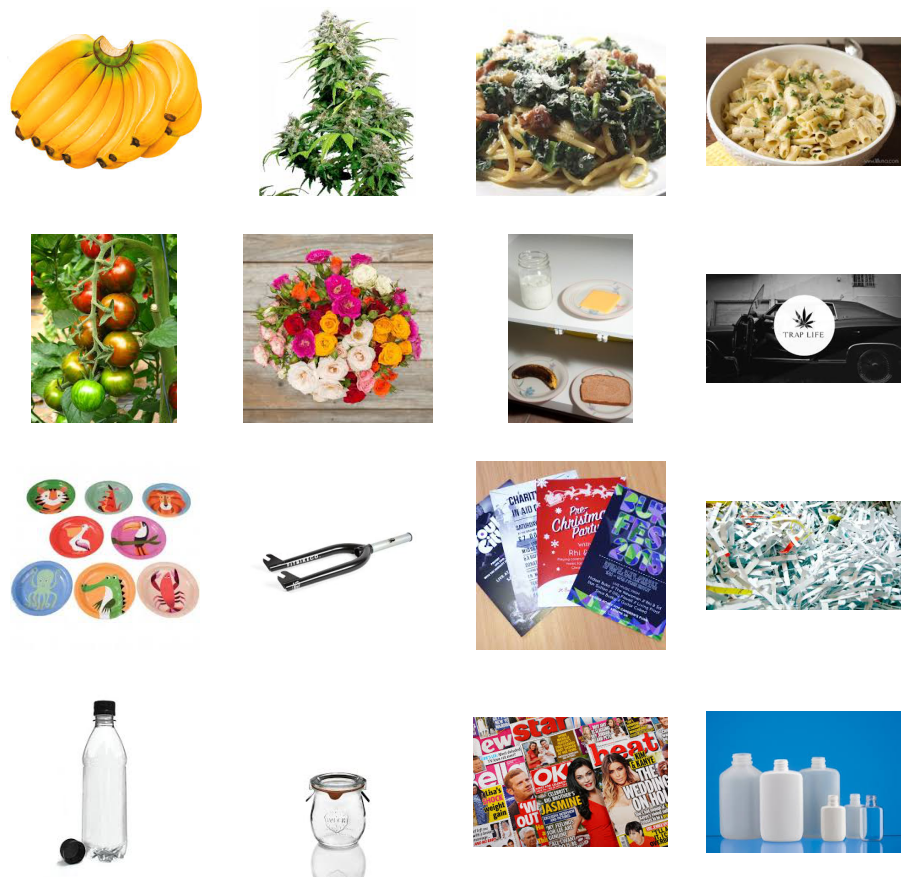

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(organic_train_dir, fname) 
                for fname in organic_train_fnames [ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(recyclable_train_dir, fname) 
                for fname in recyclable_train_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

## Creating a generic VGG block

The VGG Network has blocks of layers, where each block has a varied number of layers.
- In order to create blocks of layers that have a customizable number of conv2D layers, we'll define a class `Block`, which can generate a customizable block of layers 


### `__init__`
In the constructor `__init__`, we will store the conv2D parameters and also define the number of conv2D layers using the parameters passed into `__init__`.
- We will store the filters, kernel_size, and repetitions as class variables so that they can be used later in the `call` function.
- Using a for loop, define a number of Conv2D [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers, based on the number of `repetitions` desired for this block.
    - We will define each conv2D layer using `vars` and string formatting to create conv2D_0, conv2D_1, conv2D_3 etc.

- We will define the [MaxPool2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer that follows these Conv2D layers. 


### `call`
In `call`, we will connect the layers together.
- The 0-th conv2D layer, `conv2D_0`, immediately follows the `inputs`.
- For conv2D layers 1,2 and onward, we will use a for loop to connect conv2D_1 to conv2D_0, and connect conv2D_2 to conv2D_1, and so on.
- After connecting all of the conv2D_i layers, we will add connect the max_pool layer and return the max_pool layer.

In [ ]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        
        
        for i in range(repetitions):
            
            
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')
        
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size),strides=(strides, strides))
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)[f'conv2D_{0}'] 
        
        # Connect the conv2D_0 layer to inputs
        x = (conv2D_0)(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1, self.repetitions):
            # access conv2D_i by formatting the integer `i`.
            conv2D_i = vars(self)[f'conv2D_{i}']
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Adding max_pool layer
        max_pool = (self.max_pool)(x) 
        
        return max_pool

## Creating the Custom VGG network
This model stack has a series of VGG blocks, which can be created using the `Block` class that we defined earlier.

### `__init__`
- Recall that the `__init__` constructor of `Block` takes several function parameters, 
    - filters, kernel_size, repetitions: we'll set these.
    - kernel_size and strides: we will use the default values.
- For blocks a through e, build the blocks according to the following specifications:
- block_a: 64  filters, kernel_size 3, repetitions 2
- block_b: 128 filters, kernel_size 3, repetitions 2
- block_c: 256 filters, kernel_size 3, repetitions 3
- block_d: 512 filters, kernel_size 3, repetitions 3
- block_e: 512 filters, kernel_size 3, repetitions 3

After block 'e', we will add the following layers:
- flatten: use [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/).
- fc: create a fully connected layer using [Dense](https://keras.io/api/layers/core_layers/dense/).  We will give this 256 units, and a `'relu'` activation.
- classifier: we are goning to create the classifier using a Dense layer.  The number of units equals the number of classes.  For multi-class classification, we use a `'softmax'` activation.

### `call`
We will connect these layers together using the functional API syntax:
- inputs
- block_a
- block_b
- block_c
- block_d
- block_e
- flatten
- fc
- classifier

Return the classifier layer.

In [ ]:
class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(32, 3, 2, 2, 2) 
        self.block_b = Block(128, 3, 2, 2, 2) 
        self.block_c = Block(256, 3, 3, 2, 2) 
        self.block_d = Block(512, 3, 3, 2, 2) 
        self.block_e = Block(512, 3, 3, 2, 2)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten() 
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256, activation='relu') 
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a (inputs)
        #x = self.block_b (x)
        # x = self.block_c (x)
        # x = self.block_d (x)
        # x = self.block_e (x)
        x = self.flatten (x)
        x = self.fc(x)
        x = self.classifier (x)
        return x

In [ ]:
# create a VGG instance with 2 output units, one for each class that we want to detect
model = MyVGG(num_classes=2)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='sparse_categorical_crossentropy',# loss='categorical_crossentropy' in case more than two classes
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

#Notes about the optimizer:
 Adam is slower to change its direction, and then much slower to get back to the minimum. However, rmsprop with momentum reaches much further before it changes direction (when both use the same learning_rate).
 
 RMSProp and Momentum take contrasting approaches. While momentum accelerates our search in direction of minima, RMSProp impedes our search in direction of oscillations. Adam or Adaptive Moment Optimization algorithms combines the heuristics of both Momentum and RMSProp

### TensorBoard
 TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and  

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!rm -rf logs #Enable visualizations for TensorBoard.

##Creating the directory for tensorBoard

In [ ]:
import os
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40, 
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/WASTE_CLASSIFICATION/TRAIN',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        #  class_mode='categorical'in case we use categorical_crossentropy loss, (more than two classes)
        class_mode='binary',
         shuffle=True) #shuffling the data

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/WASTE_CLASSIFICATION/TEST',  # This is the source directory for validation images
        target_size=(300, 300),  
        batch_size=32,
        class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


Here we faced a problem. The number of classes that we have is two however the results that the the previous code showed was 3.

Colab inseted a hidden file that needs to be deleted, and the following code does that.

In [ ]:
import shutil

os.listdir("/content/WASTE_CLASSIFICATION/TEST") #First find where the ".ipynb_checkpoints" is located.

['er', 'or', '.ipynb_checkpoints']

In [ ]:
os.listdir("/content/WASTE_CLASSIFICATION/TRAIN")

['re', 'or', '.ipynb_checkpoints']

In [ ]:
shutil.rmtree("/content/WASTE_CLASSIFICATION/TEST/.ipynb_checkpoints")#delete the extra hiddin folder that causes the issue
shutil.rmtree("/content/WASTE_CLASSIFICATION/TRAIN/.ipynb_checkpoints")

OOM Erroer:

OOM stands for "out of memory". Your GPU is running out of memory, so it can't allocate memory for this tensor. There are a few things you can do:

Decrease the number of filters in your Dense, Conv2D layers

Use a smaller batch_size (or increase steps_per_epoch and validation_steps)

Use grayscale images (you can use tf.image.rgb_to_grayscale)

Reduce the number of layers

Use MaxPooling2D layers after convolutional layers

Reduce the size of your images (you can use tf.image.resize for that)

Use smaller float precision for your input, namely np.float32

If you're using a pre-trained model, freeze the first layers 



For me lowering down the size of the resized images works.


In [ ]:
history = model.fit(
      train_generator,
      #steps_per_epoch=8,   # number of training images= batch_size * steps  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[tensorboard_callback])
     

#Showing the results using classical way

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Showing the results using TensorBoard

In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


#Testing the model performance

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  #plt.imshow(img)

  #plt.show()

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)